In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# Preprocessing

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

# Modeling

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

# Evaluation

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,auc,f1_score
from sklearn.metrics import precision_recall_curve,roc_curve


#**DataSet**

Diagnostic Wisconsin Breast Cancer Database.

[link al dataset](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic)

In [2]:
%pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
b_cancer_features = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = b_cancer_features.data.features
y = b_cancer_features.data.targets

In [3]:
X.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
y.head()

,Diagnosis
0,M
1,M
2,M
3,M
4,M


**Dataset Information:**

- Diagnosis (M = malignant, B = benign) -> Target
  
Ten real-valued features (x3) are computed for cell nucleus:

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension ("coastline approximation" - 1)

![Normal_and_cancer_cells_structure.jpg](https://thumbs.dreamstime.com/b/cancer-cells-normal-cells-comparison-difference-healthy-tissue-tumor-details-chromatin-nucleus-203040708.jpg)






#**EDA and Preprocessing**

In [5]:
print(y.value_counts(), '%', y.value_counts()*100/569)  # Target

Diagnosis
B            357
M            212
dtype: int64 % Diagnosis
B            62.741652
M            37.258348
dtype: float64


We have 212 Malignant and 357 Benign cases (N=569) in the dataset, with no missing values. There is some disproportion between groups; however, since the minority class (M - 37%) not constitutes less than 20% of the total data, the data will be considered not imbalanced. So, under or oversampling techniques are not addressed.

In [6]:
X.describe(include='all').T # Features

,count,mean,std,min,25%,50%,75%,max
radius1,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
texture1,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
perimeter1,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
area1,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
smoothness1,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
compactness1,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
concavity1,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
concave_points1,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
symmetry1,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
fractal_dimension1,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


In [7]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

In [8]:
X.isnull().sum().sum()

0

All *continuos variables* with no missing values (nulls).

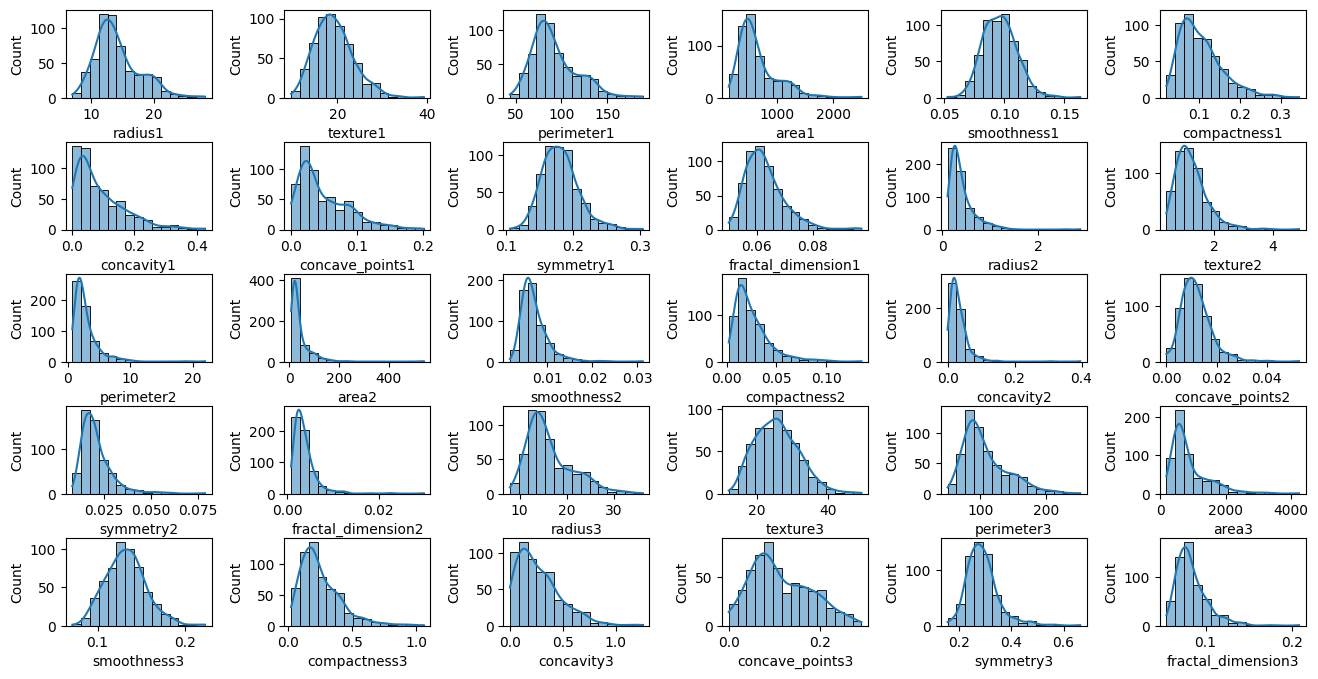

In [9]:
plt.figure(1 , figsize = (16 , 8))
n = 0
for x in X.columns:
    n += 1
    plt.subplot(5, 6, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.histplot(X, x=X[x], bins = 15, kde=True)
plt.show()

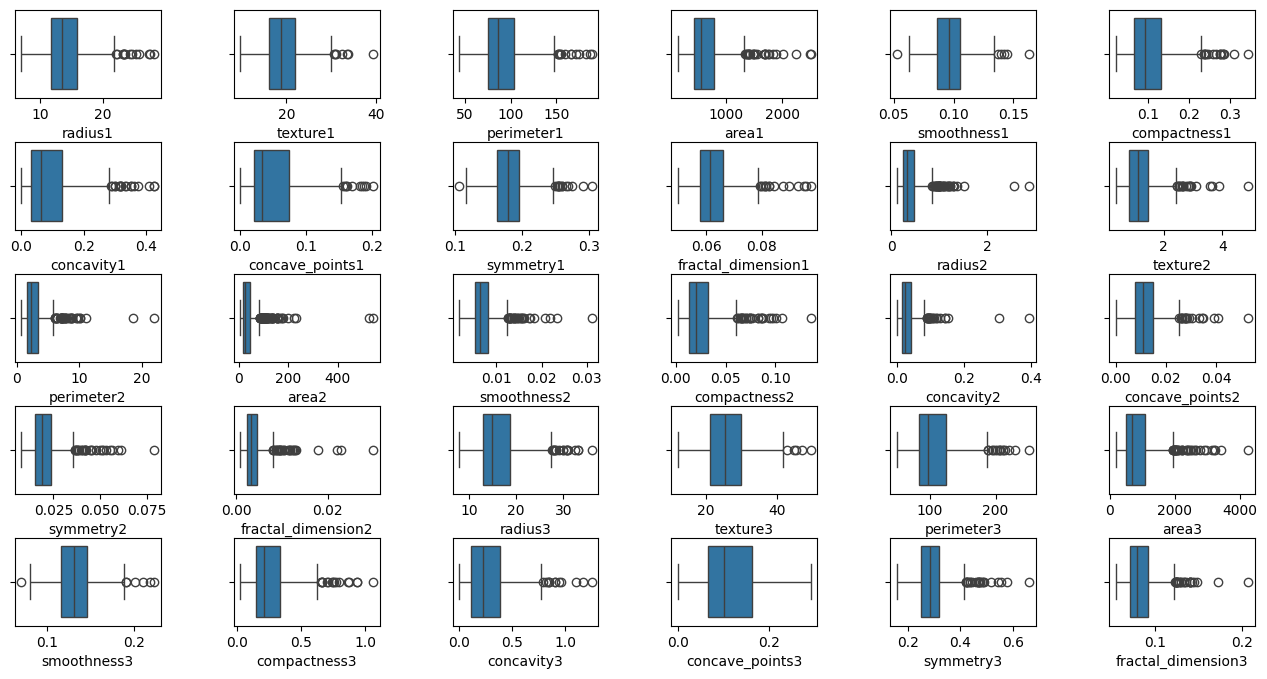

In [10]:
plt.figure(1 , figsize = (16 , 8))
n = 0
for x in X.columns:
    n += 1
    plt.subplot(5, 6, n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    sns.boxplot(X, x=X[x])
plt.show()

Excluding *concave_points3*, outliers are pesent in all the variables. In addition, there are differences in the measure scales used, therefore RobustScaler (statistics that are robust to outliers) will be used to transform features.

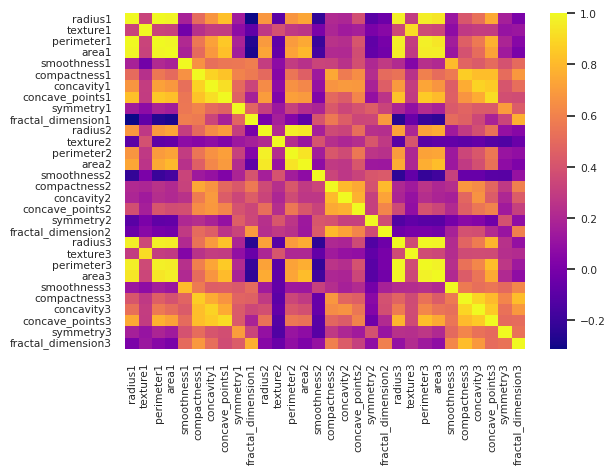

In [11]:
# Several strong correlations

sns.set(font_scale=0.7)
sns.heatmap(X.corr(), cmap='plasma')
plt.tight_layout()
plt.show()

In [12]:
# Split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [13]:
# Scaling

num_pipeline = Pipeline(steps=[('rs', RobustScaler())])

pre = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, X.columns)
    ]
    , remainder='passthrough'
    , sparse_threshold=0
    , verbose_feature_names_out=False
)

x_train_p = pd.DataFrame(data=pre.fit_transform(x_train),
                         columns=pre.get_feature_names_out())

x_test_p = pd.DataFrame(data=pre.transform(x_test)
    , columns=pre.get_feature_names_out())


y_train_p = pd.DataFrame(LabelEncoder().fit_transform(y_train), columns=['diagnosis'])

y_test_p = pd.DataFrame(LabelEncoder().fit_transform(y_test), columns=['diagnosis'])

In [14]:
x_train_p.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,1.002457,1.227027,0.991423,1.168314,0.250403,0.311221,1.117100,0.634861,-1.440476,-0.351771,...,0.601905,0.337349,0.584561,0.662036,-0.256030,-0.154933,0.207928,0.115741,-1.795522,-0.547414
1,-0.422604,-0.102703,-0.343077,-0.399128,1.158517,0.831724,0.425572,0.430367,0.491071,1.374767,...,-0.295238,0.015663,-0.227931,-0.289050,1.736549,0.412981,0.351159,0.440720,-0.217910,0.626916
2,-0.412776,-0.302703,-0.436898,-0.363663,-1.092423,-0.898139,-0.553160,-0.441057,-0.360119,-0.519577,...,-0.310476,-0.666265,-0.342022,-0.261264,-1.173284,-0.754462,-0.726402,-0.573991,-0.111940,-0.544061
3,-0.031941,1.171171,-0.072816,-0.023837,-0.431488,-0.654877,-0.350360,-0.261704,-0.514881,-0.702300,...,-0.106667,1.079518,-0.148596,-0.086831,-0.085343,-0.537032,-0.320494,-0.395305,-0.540299,-0.561782
4,1.498771,0.012613,1.467530,1.804942,0.696400,0.777666,1.716703,1.692567,0.092262,-0.042262,...,1.723810,0.616867,1.428284,2.049397,0.749536,0.856320,1.379581,1.100928,0.686567,0.501916


In [15]:
x_test_p.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,-0.164619,-0.261261,-0.172589,-0.163372,0.368619,-0.275079,-0.306383,-0.253984,-0.252976,-0.205096,...,-0.228571,-0.502410,-0.213827,-0.199711,0.267161,-0.459042,-0.458863,-0.436619,-0.176119,-0.513889
1,-0.962408,1.645045,-0.942412,-0.798837,-0.790435,-0.691019,-0.639925,-0.671088,-0.148810,-0.111871,...,-0.841905,1.080723,-0.772951,-0.670140,-0.886827,-0.718765,-0.840314,-1.010918,-0.494030,-0.475096
2,-0.125307,-0.544144,-0.115176,-0.113953,-0.297689,-0.181636,-0.030398,-0.061764,-0.258929,-0.293350,...,-0.156190,-0.713253,-0.099987,-0.139122,0.051948,0.272703,0.459611,-0.007996,0.298507,-0.076149
3,0.039312,-1.088288,-0.017154,0.058430,-1.191832,-0.900610,-0.611115,-0.583609,-1.270833,-1.011809,...,0.011429,-1.003614,-0.043068,0.040135,-1.520223,-0.787961,-0.788743,-0.784356,-0.804478,-0.847222
4,-0.984521,0.574775,-0.951164,-0.820058,-0.190220,-0.593096,-0.222501,-0.417302,-0.297619,0.530764,...,-0.964762,-0.026506,-0.864627,-0.737289,-0.775510,-0.659094,-0.541399,-0.748065,-0.553731,-0.272031


In [16]:
y_train_p.head() # M=1 B=0

,diagnosis
0,1
1,0
2,0
3,0
4,1


In [17]:
y_test_p.head()

,diagnosis
0,0
1,0
2,0
3,0
4,0


#**Models Training**

#***Logistic Regression***

In [18]:
lg = LogisticRegression(random_state=8, max_iter=1000)
param_lg = [{
    'solver':['lbfgs', 'newton-cg', 'newton-cholesky', 'sag']
    , 'C': [1, 10, 100]
    , 'penalty':['l2']
},{
    'solver':['liblinear']
    , 'C': [1, 10, 100]
    , 'penalty': ['l1', 'l2']
},{
    'solver':['saga']
    , 'C': [1, 10, 100]
    , 'penalty': ['l1', 'l2', 'elasticnet']
}]

gs_lg = GridSearchCV(
    estimator=lg
    , param_grid=param_lg
    , cv=5
    , verbose=2
    , scoring='roc_auc'
)

gs_lg.fit(x_train_p, y_train_p)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.1s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=newton-cg; total time=   0.1s
[CV] END ............C=1, penalty=l2, solver=newton-cholesky; total time=   0.1s
[CV] END ............C=1, penalty=l2, solver=ne

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=8),
             param_grid=[{'C': [1, 10, 100], 'penalty': ['l2'],
                          'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                     'sag']},
                         {'C': [1, 10, 100], 'penalty': ['l1', 'l2'],
                          'solver': ['liblinear']},
                         {'C': [1, 10, 100],
                          'penalty': ['l1', 'l2', 'elasticnet'],
                          'solver': ['saga']}],
             scoring='roc_auc', verbose=2)

In [19]:
gs_lg.best_estimator_.get_params() # Best parameters (tested) for this model.

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 8,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [20]:
# For evaluation
metrics = pd.DataFrame(columns=['Algorithm', 'Accuracy_train', 'Precision_train',
                                'Recall_train', 'f1-score_train', 'Accuracy_test',
                                'Precision_test', 'Recall_test', 'f1-score_test'])
metrics['Algorithm'] = ['Logistic Regression', 'Decision Trees', 'SVMs', 'Random Forest', 'ADABoost', 'XGBoost' ]

In [21]:
# For evaluation

cr_lg_train = classification_report(y_train_p, gs_lg.predict(x_train_p), output_dict=True)
metrics.loc[0,'Accuracy_train']=cr_lg_train['accuracy']
metrics.loc[0,'Precision_train']=cr_lg_train['1']['precision']
metrics.loc[0,'Recall_train']=cr_lg_train['1']['recall']
metrics.loc[0, 'f1-score_train']=cr_lg_train['1']['f1-score']

cr_lg_test = classification_report(y_test_p, gs_lg.predict(x_test_p), output_dict=True)
metrics.loc[0,'Accuracy_test']=cr_lg_test['accuracy']
metrics.loc[0,'Precision_test']=cr_lg_test['1']['precision']
metrics.loc[0,'Recall_test']=cr_lg_test['1']['recall']
metrics.loc[0, 'f1-score_test']=cr_lg_test['1']['f1-score']


In [22]:
# For visualization

lg_imp = pd.DataFrame(gs_lg.best_estimator_.feature_names_in_, columns=['Variables'])
lg_imp['Coefficients'] = pd.DataFrame(gs_lg.best_estimator_.coef_).T

#sns.barplot(lg_imp.sort_values('Coefficients', ascending=0), x='Coefficients', y='Variables', color='darkblue')

#***Decision Trees***

In [23]:
dt = DecisionTreeClassifier(random_state=8)
param_dt = {
    'criterion':['gini', 'log_loss', 'entropy'],
    'max_features':['sqrt', 'log2', None],
    'max_depth':[None, 10, 25, 50]
}

gs_dt = GridSearchCV(
    estimator=dt
    , param_grid=param_dt
    , cv=5
    , scoring='roc_auc'
)

gs_dt.fit(x_train_p, y_train_p)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=8),
             param_grid={'criterion': ['gini', 'log_loss', 'entropy'],
                         'max_depth': [None, 10, 25, 50],
                         'max_features': ['sqrt', 'log2', None]},
             scoring='roc_auc')

In [24]:
gs_dt.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'log_loss',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 8,
 'splitter': 'best'}

In [25]:
# For evaluation

cr_dt_train = classification_report(y_train_p, gs_dt.predict(x_train_p), output_dict=True)
metrics.loc[1,'Accuracy_train']=cr_dt_train['accuracy']
metrics.loc[1,'Precision_train']=cr_dt_train['1']['precision']
metrics.loc[1,'Recall_train']=cr_dt_train['1']['recall']
metrics.loc[1, 'f1-score_train']=cr_dt_train['1']['f1-score']

cr_dt_test = classification_report(y_test_p, gs_dt.predict(x_test_p), output_dict=True)
metrics.loc[1,'Accuracy_test']=cr_dt_test['accuracy']
metrics.loc[1,'Precision_test']=cr_dt_test['1']['precision']
metrics.loc[1,'Recall_test']=cr_dt_test['1']['recall']
metrics.loc[1, 'f1-score_test']=cr_dt_test['1']['f1-score']

In [26]:
# For visualization

dt_imp =[(feat, imp) for feat, imp in zip(gs_dt.best_estimator_.feature_names_in_, gs_dt.best_estimator_.feature_importances_)]
dt_imp = pd.DataFrame(dt_imp, columns=['col', 'f score'])

#sns.barplot(dt_imp.sort_values('f score', ascending=0), x='f score', y='col', color='darkblue')

#***SVMs***

In [27]:
svc = SVC(random_state=8)  # testing just linear kernel since the one that allows extract coefficients for features importance
param_svc = [
    {'kernel':['linear'], 'C': [1, 10, 100]}
    , {'kernel':['linear'], 'C':[1, 10, 100], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
    , {'kernel':['linear'], 'C': [1, 10, 100], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5]
       , 'degree':[2, 3, 4, 5]}
]

gs_svc = GridSearchCV(
    estimator=svc
    , param_grid=param_svc
    , cv=5
    , verbose=2
    , scoring='roc_auc'
)

gs_svc.fit(x_train_p, y_train_p)

Fitting 5 folds for each of 87 candidates, totalling 435 fits
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END .................................C=1, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ................................C=10, kernel=linear; total time=   0.0s
[CV] END ...............................C=100, kernel=linear; total time=   0.0s
[CV] END ...............................C=100, 

GridSearchCV(cv=5, estimator=SVC(random_state=8),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1, 10, 100],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
                          'kernel': ['linear']},
                         {'C': [1, 10, 100], 'degree': [2, 3, 4, 5],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5],
                          'kernel': ['linear']}],
             scoring='roc_auc', verbose=2)

In [28]:
gs_svc.best_estimator_.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'linear',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [29]:
# For evaluation

cr_svc_train = classification_report(y_train_p, gs_svc.predict(x_train_p), output_dict=True)
metrics.loc[2,'Accuracy_train']=cr_svc_train['accuracy']
metrics.loc[2,'Precision_train']=cr_svc_train['1']['precision']
metrics.loc[2,'Recall_train']=cr_svc_train['1']['recall']
metrics.loc[2, 'f1-score_train']=cr_svc_train['1']['f1-score']

cr_svc_test = classification_report(y_test_p, gs_svc.predict(x_test_p), output_dict=True)
metrics.loc[2,'Accuracy_test']=cr_svc_test['accuracy']
metrics.loc[2,'Precision_test']=cr_svc_test['1']['precision']
metrics.loc[2,'Recall_test']=cr_svc_test['1']['recall']
metrics.loc[2, 'f1-score_test']=cr_svc_test['1']['f1-score']


In [30]:
# For visualization

svm_imp = pd.DataFrame(gs_svc.best_estimator_.feature_names_in_, columns=['Variables']) # only linear kernerl
svm_imp['Coefficients'] = pd.DataFrame(gs_svc.best_estimator_.coef_).T

#sns.barplot(svm_imp.sort_values('Coefficients', ascending=0), y='Variables', x='Coefficients', color='darkblue')

#***Random Forest***

In [31]:
rf = RandomForestClassifier(random_state=8)
param_rf = {
    'criterion':['gini', 'log_loss', 'entropy'],
    'max_features':['sqrt', 'log2', None],
    'max_depth':[None, 10, 25, 50],
    'n_estimators':[10, 25, 50, 100]
}

gs_rf = GridSearchCV(
    estimator=rf
    , param_grid = param_rf
    , cv=5
    , scoring='roc_auc'
)

gs_rf.fit(x_train_p, y_train_p)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=8),
             param_grid={'criterion': ['gini', 'log_loss', 'entropy'],
                         'max_depth': [None, 10, 25, 50],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='roc_auc')

In [32]:
gs_rf.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 8,
 'verbose': 0,
 'warm_start': False}

In [33]:
# For evaluation

cr_rf_train = classification_report(y_train_p, gs_rf.predict(x_train_p), output_dict=True)
metrics.loc[3,'Accuracy_train']=cr_rf_train['accuracy']
metrics.loc[3,'Precision_train']=cr_rf_train['1']['precision']
metrics.loc[3,'Recall_train']=cr_rf_train['1']['recall']
metrics.loc[3, 'f1-score_train']=cr_rf_train['1']['f1-score']

cr_rf_test = classification_report(y_test_p, gs_rf.predict(x_test_p), output_dict=True)
metrics.loc[3,'Accuracy_test']=cr_rf_test['accuracy']
metrics.loc[3,'Precision_test']=cr_rf_test['1']['precision']
metrics.loc[3,'Recall_test']=cr_rf_test['1']['recall']
metrics.loc[3, 'f1-score_test']=cr_rf_test['1']['f1-score']

In [34]:
# For visualization

rf_imp =[(feat, imp) for feat, imp in zip(gs_rf.best_estimator_.feature_names_in_, gs_rf.best_estimator_.feature_importances_)]
rf_imp = pd.DataFrame(rf_imp, columns=['col', 'f score'])

#sns.barplot(rf_imp.sort_values('f score', ascending=0), y='col', x='f score', color='darkblue')

#***ADABoost***

In [35]:
ada = AdaBoostClassifier(random_state=0)
param_ada = {
    'n_estimators':[10, 25, 50, 100]
    , 'learning_rate':[0.3, 0.5, 1.0]
}

gs_ada = GridSearchCV(
    estimator=ada
    , cv = 5
    , verbose=2
    , param_grid=param_ada
    , scoring='roc_auc'
)

gs_ada.fit(x_train_p, y_train_p)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.0s
[CV] END .................learning_rate=0.3, n_estimators=10; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=25; total time=   0.1s
[CV] END .................learning_rate=0.3, n_estimators=50; total time=   0.2s
[CV] END .................learning_rate=0.3, n_e

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=0),
             param_grid={'learning_rate': [0.3, 0.5, 1.0],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='roc_auc', verbose=2)

In [36]:
gs_ada.best_estimator_.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 0}

In [37]:
# For evaluation

cr_ada_train = classification_report(y_train_p, gs_ada.predict(x_train_p), output_dict=True)
metrics.loc[4,'Accuracy_train']=cr_ada_train['accuracy']
metrics.loc[4,'Precision_train']=cr_ada_train['1']['precision']
metrics.loc[4,'Recall_train']=cr_ada_train['1']['recall']
metrics.loc[4, 'f1-score_train']=cr_ada_train['1']['f1-score']

cr_ada_test = classification_report(y_test_p, gs_ada.predict(x_test_p), output_dict=True)
metrics.loc[4,'Accuracy_test']=cr_ada_test['accuracy']
metrics.loc[4,'Precision_test']=cr_ada_test['1']['precision']
metrics.loc[4,'Recall_test']=cr_ada_test['1']['recall']
metrics.loc[4, 'f1-score_test']=cr_ada_test['1']['f1-score']

In [38]:
# For visualization

ada_imp =[(feat, imp) for feat, imp in zip(gs_ada.best_estimator_.feature_names_in_, gs_ada.best_estimator_.feature_importances_)]
ada_imp = pd.DataFrame(ada_imp, columns=['col', 'f score'])

#sns.barplot(ada_imp.sort_values('f score', ascending=0), y='col', x='f score', color='darkblue')

#***XGBoost***

In [39]:
param_xgb = {"objective":["binary:logistic"]
          ,'colsample_bytree': [0.3],
          'learning_rate': [0.1],
          'max_depth': [5, 10, 15]
          ,'alpha': [10]}

gs_xgb = GridSearchCV(
    estimator=XGBClassifier(random_state=0)
    , cv=5
    , scoring='roc_auc'
    , verbose=2
    , param_grid=param_xgb
)

gs_xgb.fit(x_train_p, y_train_p)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=5, objective=binary:logistic; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=10, objective=binary:logistic; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=10, objective=binary:logistic; total time=   0.1s
[CV] END alpha=10, colsample_bytree=0.3, learning_rate=0.1, max_depth=10, objective=binary:logistic; tota

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'alpha': [10], 'colsample_bytree': [0.3],
                         'learning_rate': [0.1], 'max_depth': [5, 10, 15],
                         'objective': ['binary:logistic']},
             scoring='roc_auc', verbose=2)

In [40]:
gs_xgb.best_estimator_.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.3,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 5,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 0,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'alpha': 10}

In [41]:
# For evaluation

cr_xgb_train = classification_report(y_train_p, gs_xgb.predict(x_train_p), output_dict=True)
metrics.loc[5,'Accuracy_train']=cr_xgb_train['accuracy']
metrics.loc[5,'Precision_train']=cr_xgb_train['1']['precision']
metrics.loc[5,'Recall_train']=cr_xgb_train['1']['recall']
metrics.loc[5, 'f1-score_train']=cr_xgb_train['1']['f1-score']

cr_xgb_test = classification_report(y_test_p, gs_xgb.predict(x_test_p), output_dict=True)
metrics.loc[5,'Accuracy_test']=cr_xgb_test['accuracy']
metrics.loc[5,'Precision_test']=cr_xgb_test['1']['precision']
metrics.loc[5,'Recall_test']=cr_xgb_test['1']['recall']
metrics.loc[5, 'f1-score_test']=cr_xgb_test['1']['f1-score']

In [42]:
# For visualization

xgb_imp =[(feat, imp) for feat, imp in zip(gs_xgb.best_estimator_.feature_names_in_, gs_xgb.best_estimator_.feature_importances_)]
xgb_imp = pd.DataFrame(xgb_imp, columns=['col', 'f score'])

#sns.barplot(xgb_imp.sort_values('f score', ascending=0), y='col', x='f score', color='darkblue')

#**Models Evaluation**

***Features importance for each model tested***

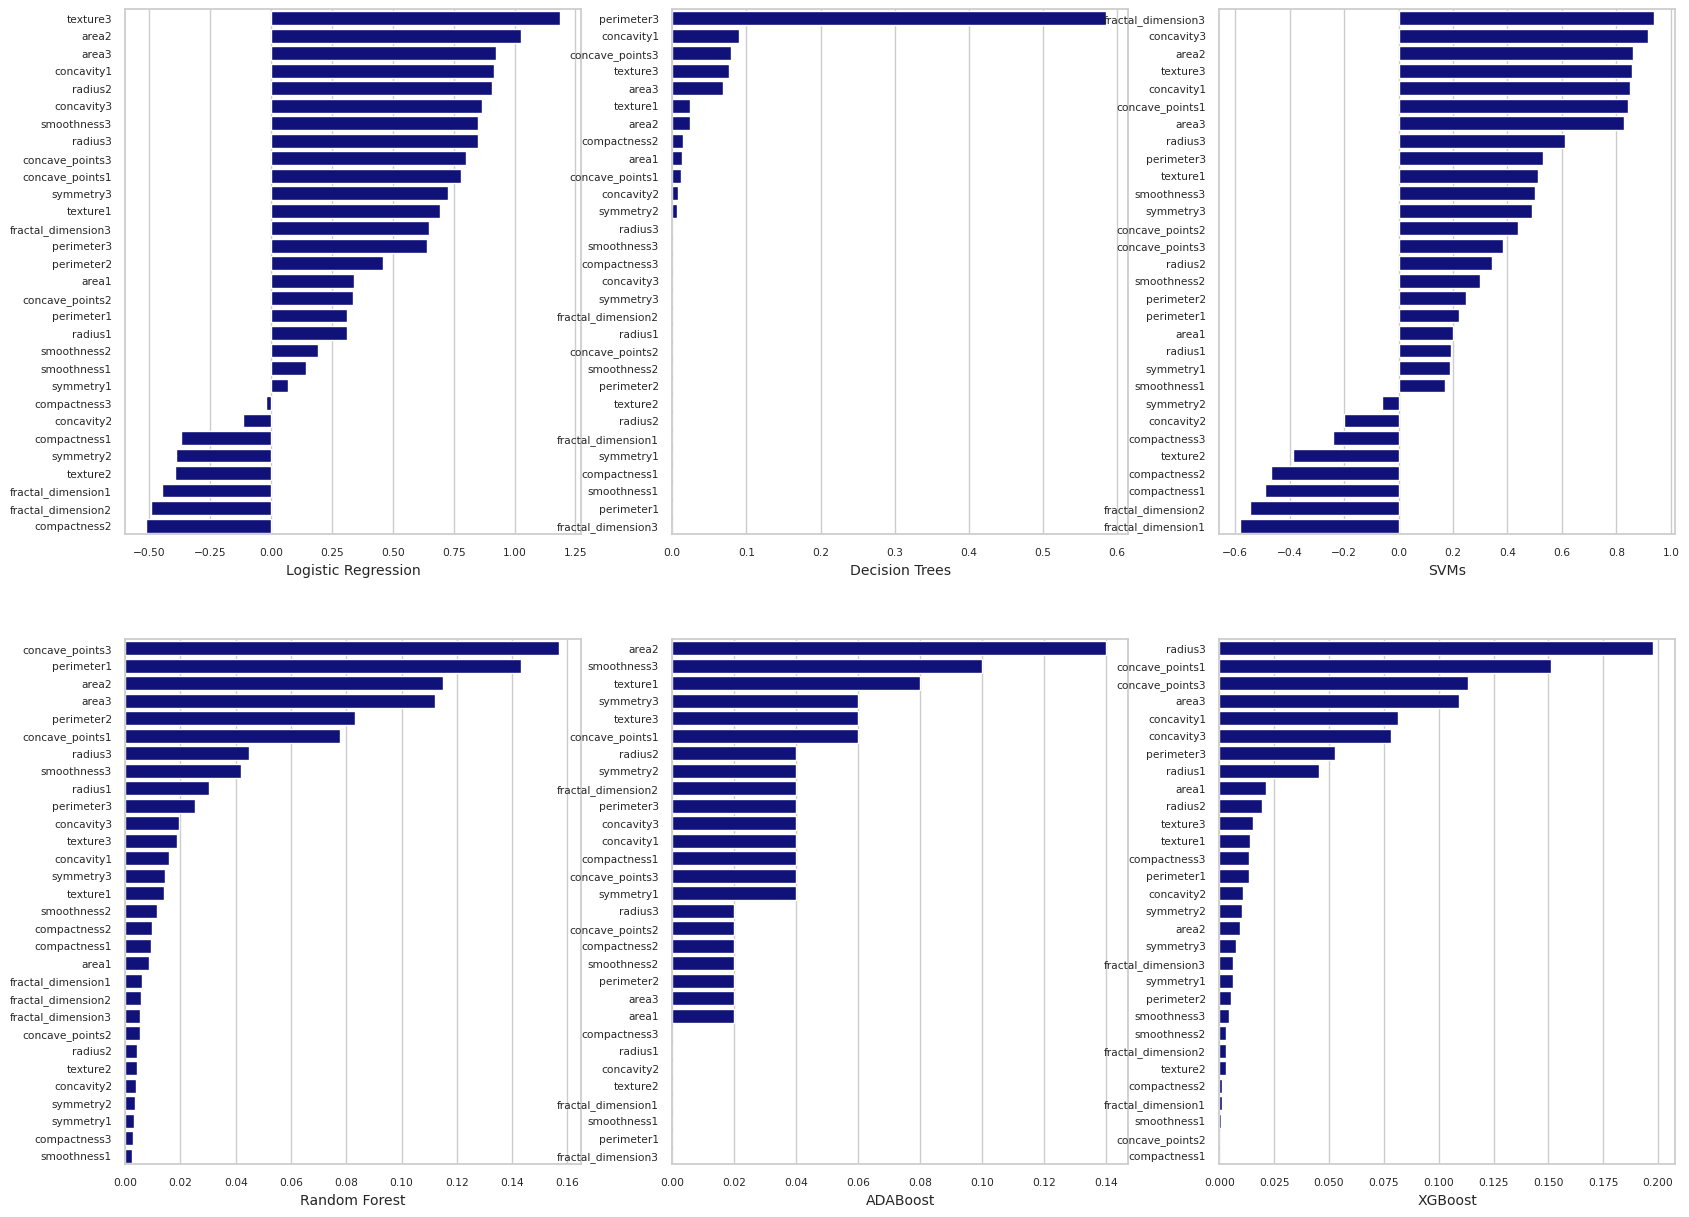

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,15))
sns.set_style('whitegrid')

sns.barplot(lg_imp.sort_values('Coefficients', ascending=0), x='Coefficients', y='Variables', ax=axes[0,0], color='darkblue')
sns.barplot(dt_imp.sort_values('f score', ascending=0), x='f score', y='col', ax=axes[0,1], color='darkblue')
sns.barplot(svm_imp.sort_values('Coefficients', ascending=0), x='Coefficients', y='Variables', ax=axes[0,2], color='darkblue')
sns.barplot(rf_imp.sort_values('f score', ascending=0), x='f score', y='col', ax=axes[1,0], color='darkblue')
sns.barplot(ada_imp.sort_values('f score', ascending=0), x='f score', y='col', ax=axes[1,1], color='darkblue')
sns.barplot(xgb_imp.sort_values('f score', ascending=0), x='f score', y='col', ax=axes[1,2], color='darkblue')

axes[0,0].set_xlabel('Logistic Regression', fontsize='large')
axes[0,1].set_xlabel('Decision Trees', fontsize='large')
axes[0,2].set_xlabel('SVMs', fontsize='large')
axes[1,0].set_xlabel('Random Forest', fontsize='large')
axes[1,1].set_xlabel('ADABoost', fontsize='large')
axes[1,2].set_xlabel('XGBoost', fontsize='large')

axes[0,0].set_ylabel('')
axes[0,1].set_ylabel('')
axes[0,2].set_ylabel('')
axes[1,0].set_ylabel('')
axes[1,1].set_ylabel('')
axes[1,2].set_ylabel('')

plt.show()

***Metrics by Model***

In [44]:
metrics

,Algorithm,Accuracy_train,Precision_train,Recall_train,f1-score_train,Accuracy_test,Precision_test,Recall_test,f1-score_test
0,Logistic Regression,0.989011,0.993865,0.975904,0.984802,0.982456,0.978261,0.978261,0.978261
1,Decision Trees,1.0,1.0,1.0,1.0,0.947368,0.934783,0.934783,0.934783
2,SVMs,0.986813,0.993827,0.96988,0.981707,0.982456,0.978261,0.978261,0.978261
3,Random Forest,1.0,1.0,1.0,1.0,0.938596,0.953488,0.891304,0.921348
4,ADABoost,1.0,1.0,1.0,1.0,0.973684,0.957447,0.978261,0.967742
5,XGBoost,0.986813,1.0,0.963855,0.981595,0.947368,0.97619,0.891304,0.931818


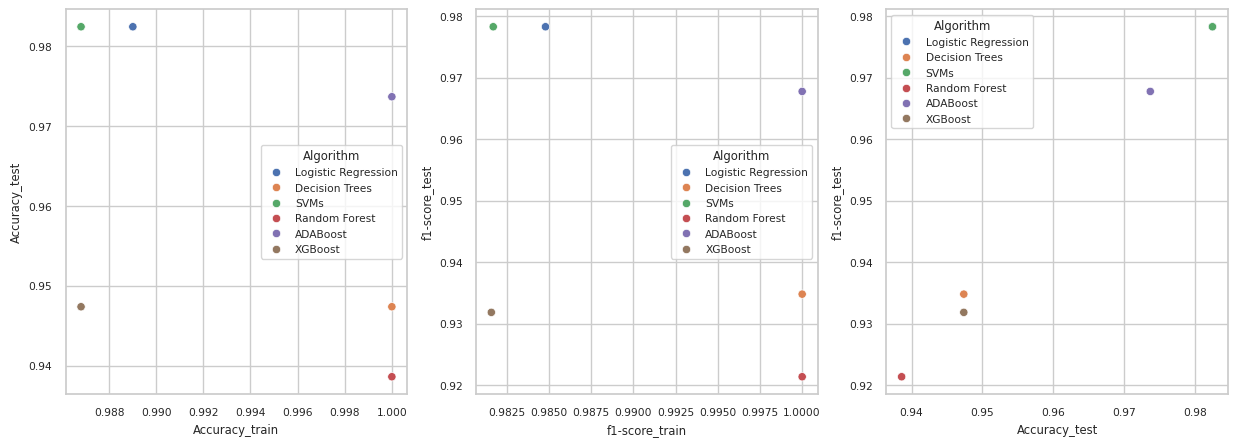

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.scatterplot(metrics, x='Accuracy_train', y='Accuracy_test', hue='Algorithm', ax=axes[0] )
sns.scatterplot(metrics, x='f1-score_train', y='f1-score_test', hue='Algorithm', ax=axes[1])
sns.scatterplot(metrics, x='Accuracy_test', y='f1-score_test', hue='Algorithm', ax=axes[2])

plt.show()

Considering the accuracy and f1-scored metrics all tested models perform well for the training dataset (>0.98). However, for the test set these values tend to decrease for the Decision Trees, Random Forest and XGBoost models, which may indicate some small degree of overfitting.  Considering these values for the test dataset the best fits are achieved by the SVMs and Logistic Regression models, followed by ADABoost; the former (SVMs) being the one with best fit for this dataset and Random Forest the worst. In this sense, it is interesting to explore the biological relationship/causality between the variables that contribute most to the best fitting models (SVMs and Logistic Regression) and the prognosis of malignancy in breast cancer.